**Install and Import Libraries**

In [ ]:
# Install imbalanced-learn (only needed in Colab or new environments)

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')


 Load Dataset

In [4]:
# Read dataset
df = pd.read_csv('/Users/sabbirahmad/Downloads/movie_ratings_dataset.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1200, 12)


,Genre,Director_Popularity,Budget_MillionUSD,Runtime_Minutes,Release_Year,Num_Main_Actors,Avg_Actor_Popularity,Has_Famous_Producer,Num_Awards_Won,Marketing_Spend_MillionUSD,Is_Sequel,Rating_Category
0,Sci-Fi,5.80,134.63,141.0,NaN,1.0,2.72,No,9.0,25.48,No,Excellent
1,Action,2.27,220.47,98.0,2006.0,1.0,3.46,Yes,17.0,9.13,Yes,Excellent
2,Horror,1.23,52.79,160.0,2010.0,2.0,NaN,NaN,43.0,6.16,No,Excellent
3,Action,8.17,86.41,153.0,2022.0,4.0,5.21,NaN,7.0,2.99,No,Good
4,Romance,6.40,259.57,134.0,1986.0,1.0,8.72,Yes,25.0,0.89,No,Excellent


Basic Info and Statistical Summary

In [5]:
print("\nData types and missing values:")
print(df.info())

print("\nStatistical summary:")
print(df.describe(include='all'))



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Genre                       1071 non-null   object 
 1   Director_Popularity         1067 non-null   float64
 2   Budget_MillionUSD           1096 non-null   float64
 3   Runtime_Minutes             1074 non-null   float64
 4   Release_Year                1088 non-null   float64
 5   Num_Main_Actors             1075 non-null   float64
 6   Avg_Actor_Popularity        1066 non-null   float64
 7   Has_Famous_Producer         1071 non-null   object 
 8   Num_Awards_Won              1061 non-null   float64
 9   Marketing_Spend_MillionUSD  1089 non-null   float64
 10  Is_Sequel                   1083 non-null   object 
 11  Rating_Category             1200 non-null   object 
dtypes: float64(8), object(4)
memory usage: 112.6+ KB
None

Sta

EDA – Visualizations

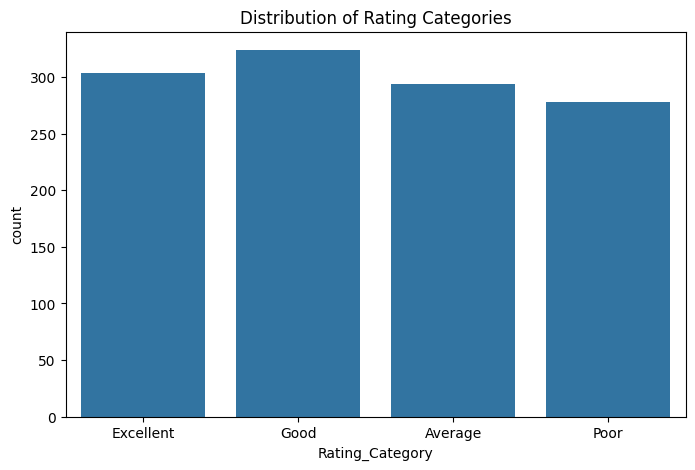

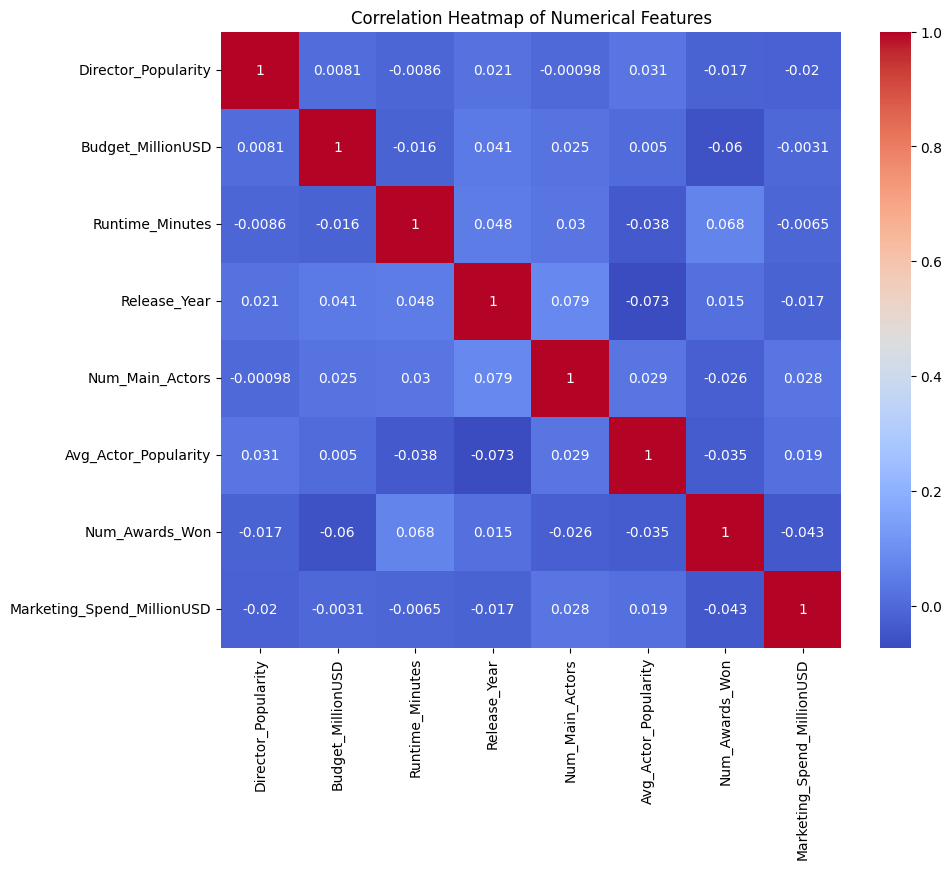

In [6]:
# Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Rating_Category', data=df)
plt.title('Distribution of Rating Categories')
plt.show()

# Correlation heatmap
numerical_features = ['Director_Popularity', 'Budget_MillionUSD', 'Runtime_Minutes', 
                     'Release_Year', 'Num_Main_Actors', 'Avg_Actor_Popularity', 
                     'Num_Awards_Won', 'Marketing_Spend_MillionUSD']
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


Preprocessing – Feature Engineering

In [7]:
X = df.drop('Rating_Category', axis=1)
y = df['Rating_Category']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

categorical_features = ['Genre', 'Has_Famous_Producer', 'Is_Sequel']
numerical_features = ['Director_Popularity', 'Budget_MillionUSD', 'Runtime_Minutes',
                      'Release_Year', 'Num_Main_Actors', 'Avg_Actor_Popularity',
                      'Num_Awards_Won', 'Marketing_Spend_MillionUSD']

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])


Train/Test Split and Handle Imbalance

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)


Model Training and Evaluation

In [10]:
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Neural Network': MLPClassifier(random_state=42, max_iter=2000, early_stopping=True)
}

results = {}

for name, model in models.items():
    pipeline = make_imb_pipeline(preprocessor, SMOTE(random_state=42), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'model': pipeline
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)



KNN Results:
Accuracy: 0.2500
Classification Report:
              precision    recall  f1-score   support

     Average       0.23      0.32      0.27        88
   Excellent       0.33      0.31      0.32        91
        Good       0.23      0.19      0.20        97
        Poor       0.23      0.19      0.21        84

    accuracy                           0.25       360
   macro avg       0.25      0.25      0.25       360
weighted avg       0.25      0.25      0.25       360

Confusion Matrix:
[[28 20 18 22]
 [24 28 22 17]
 [40 23 18 16]
 [31 15 22 16]]

Decision Tree Results:
Accuracy: 0.2333
Classification Report:
              precision    recall  f1-score   support

     Average       0.23      0.25      0.24        88
   Excellent       0.27      0.27      0.27        91
        Good       0.20      0.20      0.20        97
        Poor       0.23      0.21      0.22        84

    accuracy                           0.23       360
   macro avg       0.23      0.23      0.2

Hyperparameter Tuning (KNN)

In [11]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

knn_pipeline = make_imb_pipeline(preprocessor, SMOTE(random_state=42), KNeighborsClassifier())
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best KNN Parameters:", grid_search.best_params_)
print("Best KNN Accuracy:", grid_search.best_score_)


Best KNN Parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Best KNN Accuracy: 0.25595238095238093


Accuracy Comparison Plot

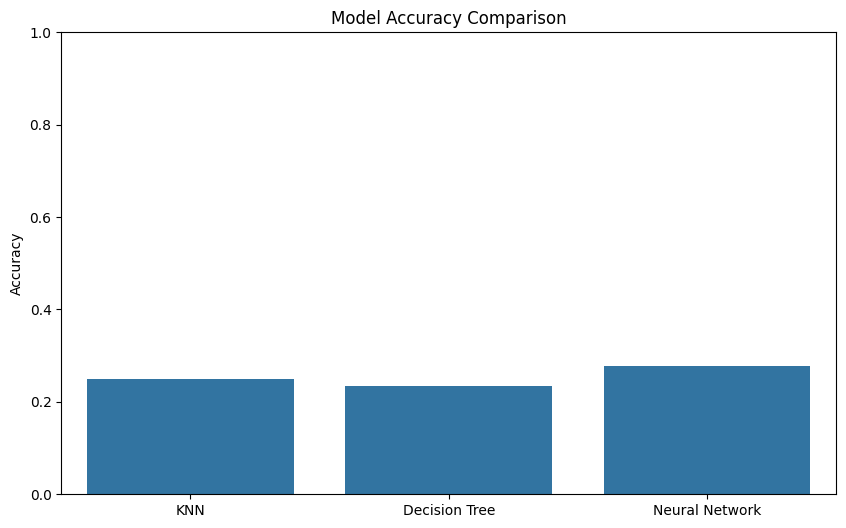

In [12]:
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10,6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


 Feature Importance (Decision Tree)

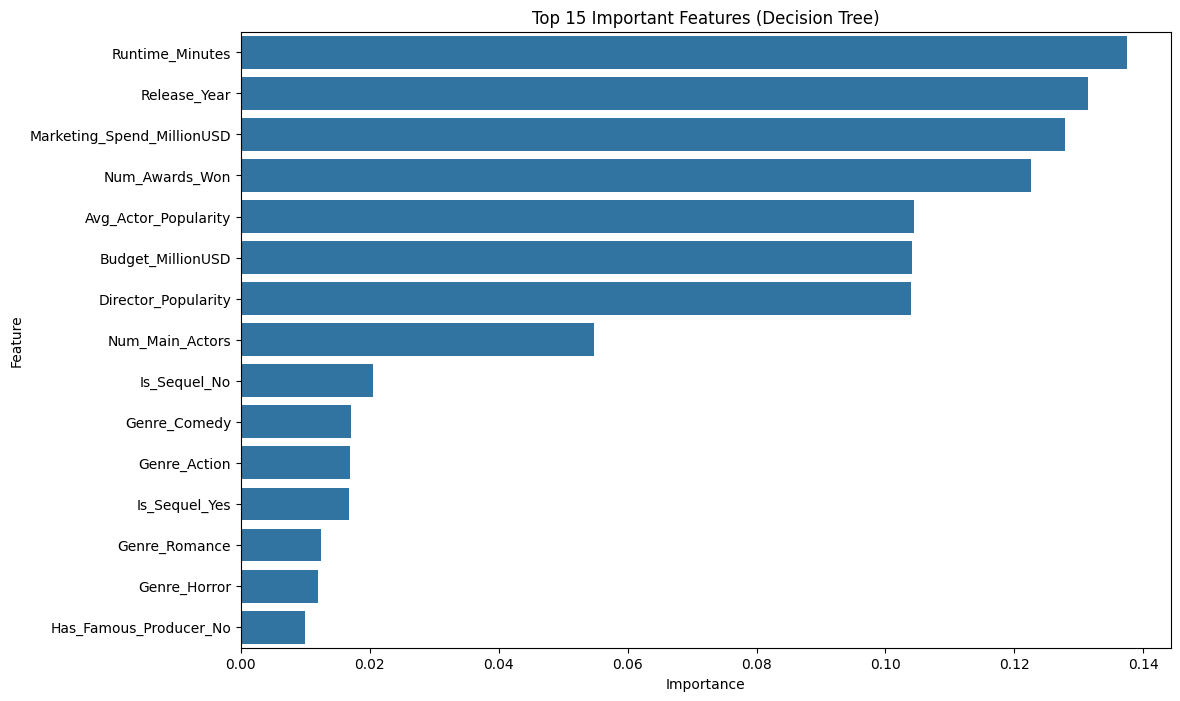

In [13]:
dt_model = results['Decision Tree']['model'].steps[-1][1]

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numerical_features + list(cat_features)

feature_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Important Features (Decision Tree)')
plt.show()


ROC Curve (Neural Network)

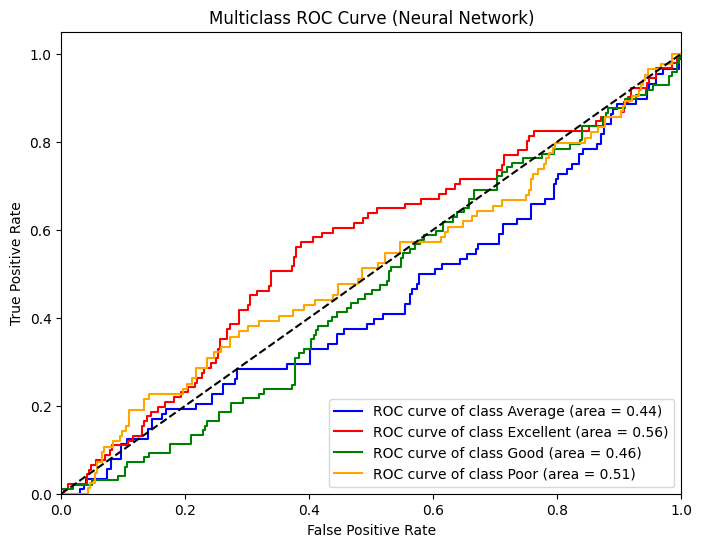

In [14]:
nn_model = results['Neural Network']['model']
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]
y_score = nn_model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Neural Network)')
plt.legend(loc="lower right")
plt.show()
